Traditional Model without dueling dqn


Adapting normalizer...

Episode 1/300
  Reward: -615.6
  Completed Tasks: 10/10
  Total Energy: 12.2kJ (Budget: 10.0kJ)
  Local/Edge Tasks: 3/7
  Action Distribution: [3, 2, 5]
  Exploration Parameters: ε=0.995, β=0.400
  System Energy Usage: 0.0kJ
  Battery Status:
    Initial Mobile: 54.6kJ
    Final Mobile: 52.0kJ
    Initial Edge: 850.7kJ
    Final Edge: 848.6kJ
  File Processing Details:
    Task 1: 364MB processed at ES1 using 1307.8J
    Task 2: 480MB processed at ES1 using 1724.6J
    Task 3: 237MB processed at ES1 using 851.5J
    Task 4: 522MB processed at ES0 using 2056.3J
    Task 5: 249MB processed at ES0 using 953.2J
    Task 6: 509MB processed at MD0 using 1300.7J
    Task 7: 301MB processed at MD1 using 678.8J
    Task 8: 280MB processed at ES1 using 1006.0J
    Task 9: 299MB processed at MD0 using 764.1J
    Task 10: 458MB processed at ES1 using 1594.5J

Episode 2/300
  Reward: -551.0
  Completed Tasks: 10/10
  Total Energy: 11.6kJ (Budget: 10.0kJ)
  Local/Edge Tasks:

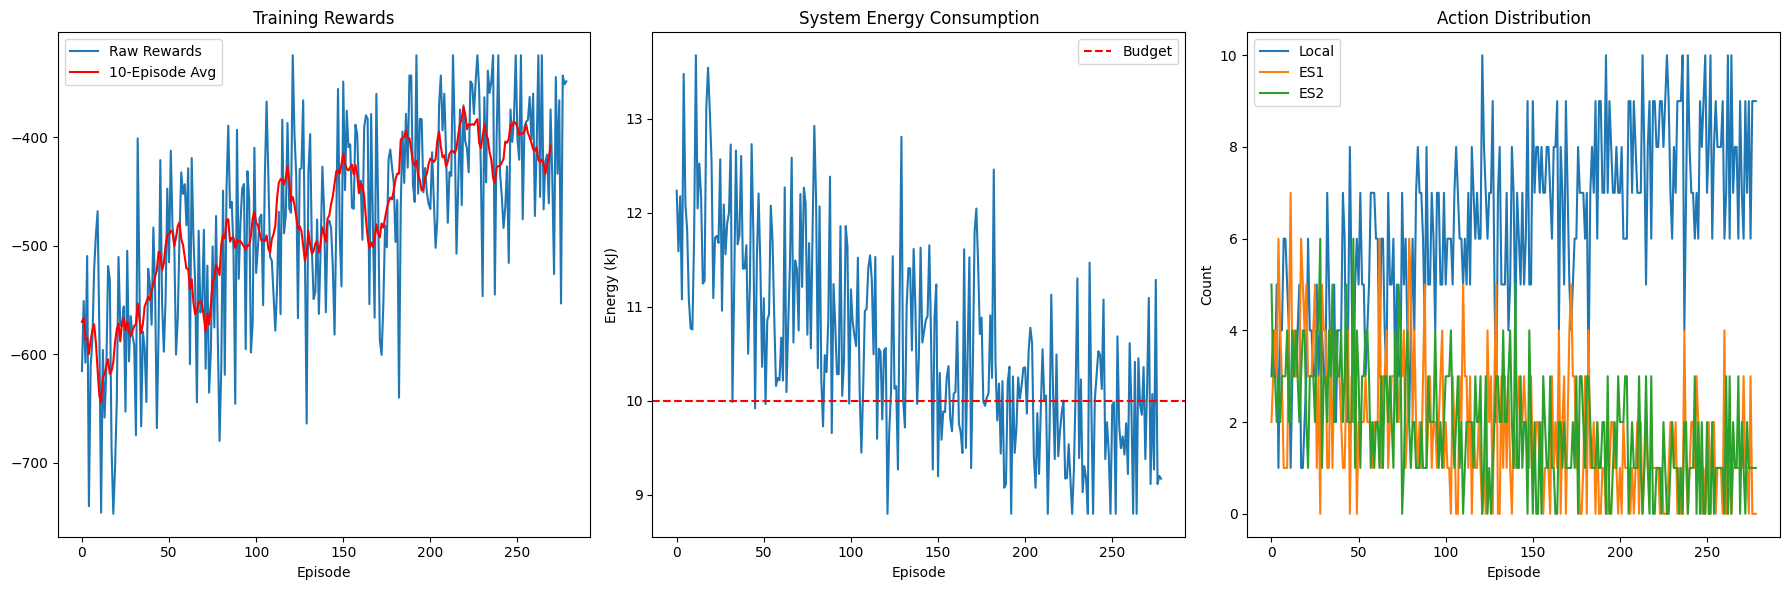

In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os


class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        # Disable dynamic alpha adjustment
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)


    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        
        # Reward parameters
        self.task_reward = 8.0
        self.energy_penalty_scale = 0.0015
        self.budget_penalty = 12.0
        self.efficiency_bonus = 2.0
        self.energy_budget = 10000
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
        # Battery history for trend analysis
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        
        self.reset()

    def reset(self):
        # Battery initialization
        self.initial_md_battery = np.random.randint(3500, 5501, self.num_md)
        self.initial_es_battery = np.random.randint(12000, 25001, self.num_es)
        
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        
        # Energy budget constraints
        self.energy_budget = 10000  # kJ
        self.energy_used = 0
        self.total_energy = 0
        
        # Task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Initialize battery history with full array copies
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        # Handle terminal state first
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            # Fallback state size calculation if shape not initialized
            state_size = 7 + self.num_es * 5 + 2  # MD features + ES features + system
            return np.zeros(state_size)

        # Verify valid task index
        if self.current_task >= len(self.task_to_md):
            raise ValueError(f"Invalid task index {self.current_task}")
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = 5000 * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = 20000 * self.MAH_TO_J * self.VOLTAGE_ES
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        # Battery trends
        
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy,
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / max_es_energy,
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                es_trend / max_es_energy
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.energy_used / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}
        
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = min(action - 1, self.num_es - 1)
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            # Calculate rewards
            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        # Energy budget constraints
        self.total_energy += energy_used
        if self.total_energy > self.energy_budget:
            reward -= self.budget_penalty

        # Update battery history
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}

class TraditionalDQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        # Same hyperparameters as advanced model
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes
        
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        
        # Paper-aligned simple architecture
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='relu')(x)
            
        outputs = tf.keras.layers.Dense(self.action_size)(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model
      
    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()


def train_agent(episodes=300):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = TraditionalDQNAgent(state_size, 1 + env.num_es, episodes)

    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    betas = []

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        
        # Capture initial state
        initial_md_battery = env.md_battery.copy()
        initial_es_battery = env.es_battery.copy()
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            # Collect file processing details
            file_details.append(info.get("file_info", {}))
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update network
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        betas.append(agent.beta)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 50:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    plt.figure(figsize=(18, 6))
    
    # Reward progression
    plt.subplot(1, 3, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(1, 3, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(1, 3, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    results = train_agent()

STress testing in old model

Adapting normalizer...

Episode 1/400
  Reward: -2124.1
  Completed Tasks: 32/50
  Total Energy: 39.8kJ (Budget: 69.0kJ)
  Local/Edge Tasks: 12/38
  Action Distribution: [12, 10, 13, 3, 12]
  Exploration Parameters: ε=0.995, β=0.400
  System Energy Usage: 0.0kJ
  Battery Status:
    Initial Mobile: 3.4kJ
    Final Mobile: 0.8kJ
    Initial Edge: 8.6kJ
    Final Edge: 5.4kJ
  File Processing Details:

Episode 2/400
  Reward: -2321.9
  Completed Tasks: 36/50
  Total Energy: 44.7kJ (Budget: 69.0kJ)
  Local/Edge Tasks: 9/41
  Action Distribution: [9, 8, 9, 11, 13]
  Exploration Parameters: ε=0.990, β=0.400
  System Energy Usage: 0.0kJ
  Battery Status:
    Initial Mobile: 3.4kJ
    Final Mobile: 0.7kJ
    Initial Edge: 8.6kJ
    Final Edge: 4.4kJ
  File Processing Details:

Episode 3/400
  Reward: -2309.3
  Completed Tasks: 34/50
  Total Energy: 43.2kJ (Budget: 69.0kJ)
  Local/Edge Tasks: 11/39
  Action Distribution: [11, 6, 9, 10, 14]
  Exploration Parameters: ε=0.985, β=0.400
  System En

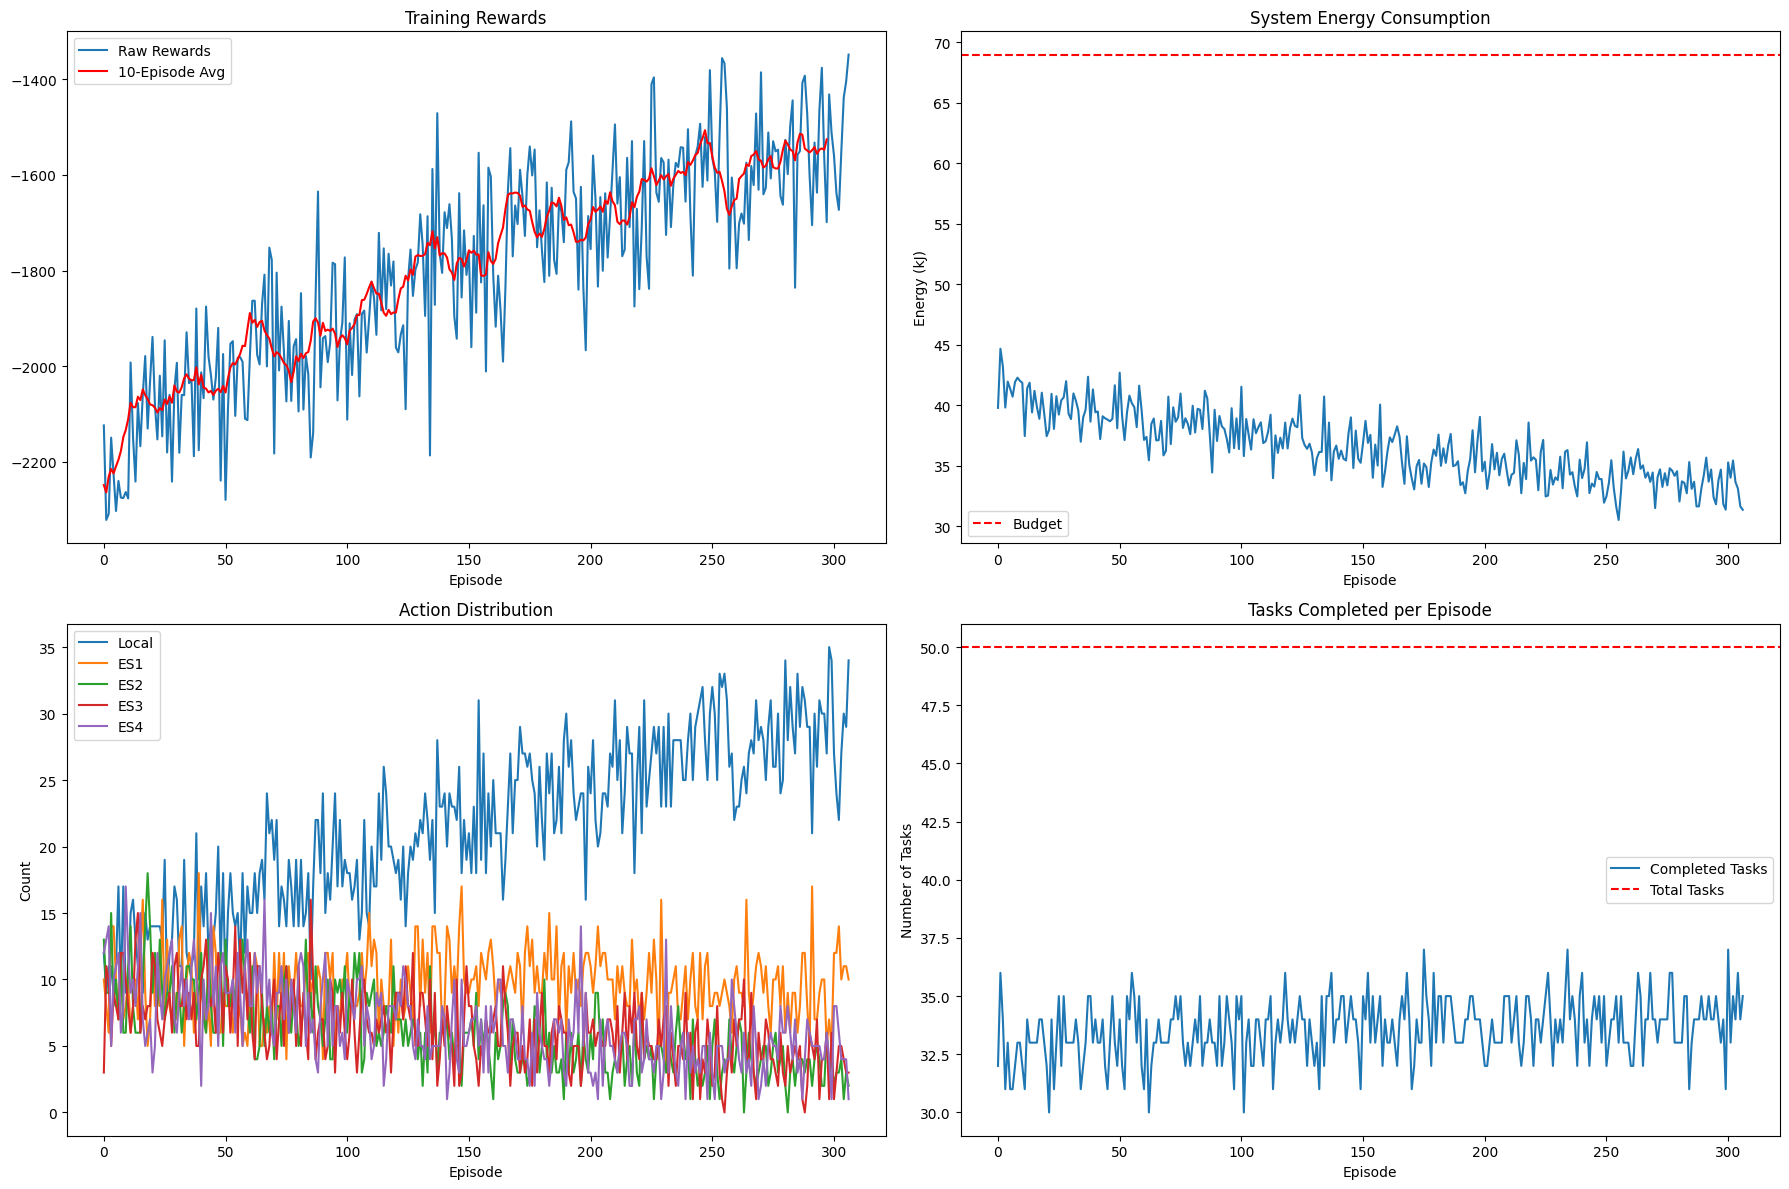

In [4]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import psutil
import time
import random
import os


class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45  # Watts
        self.start_time = None

    def start(self):
        self.start_time = time.time()

    def stop(self):
        duration = time.time() - self.start_time
        avg_cpu_usage = psutil.cpu_percent() / 100
        cpu_energy = self.CPU_TDP * avg_cpu_usage * duration
        return {
            "cpu_j": cpu_energy,
            "total_j": cpu_energy,
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0
        self.alpha = 0.6

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, episode, total_episodes, beta=0.4):
        # Disable dynamic alpha adjustment
        priorities = self.priorities[:len(self.buffer)] ** self.alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)


    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=10, num_es=4, num_tasks=50):
        self.state_shape = None
        self.total_energy = 0
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.VOLTAGE_MD = 3.7
        self.VOLTAGE_ES = 12.0
        self.MAH_TO_J = 3.6
        self.operations_per_mb = 1e9
        
        # Reward parameters
        self.task_reward = 8.0
        self.energy_penalty_scale = 0.0015
        self.budget_penalty = 12.0
        self.efficiency_bonus = 2.0
        self.energy_budget = 10000
        
        # System parameters
        self.md_compute = np.random.uniform(1.5, 3.5, num_md)
        self.es_compute = np.random.uniform(25.0, 35.0, num_es)
        self.task_requirements = np.random.randint(150, 600, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.md_energy_local = np.random.uniform(4.0, 10.0, num_md)
        self.md_energy_tx = np.random.uniform(0.6, 1.2, num_md)
        self.es_energy_process = np.random.uniform(35.0, 65.0, num_es)
        
         # New energy optimization calculations
        self.optimal_actions = []
        self.md_energy_required = np.zeros(num_md)
        self.es_energy_required = np.zeros(num_es)
        self.minimal_total_energy = 0
        
        # Calculate optimal energy requirements
        for task in range(num_tasks):
            md_idx = self.task_to_md[task]
            task_size = self.task_requirements[task]
            
            # Local processing energy
            local_energy = ((self.md_energy_local[md_idx] * 
                           (task_size * 1e9)) / (self.md_compute[md_idx]*1e9))
            
            # Find minimal offload energy
            min_offload = float('inf')
            best_es = -1
            for es_idx in range(num_es):
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = ((self.es_energy_process[es_idx] * 
                                 task_size*1e9) / (self.es_compute[es_idx]*1e9))
                total_offload = tx_energy + process_energy
                if total_offload < min_offload:
                    min_offload = total_offload
                    best_es = es_idx

            # Track optimal energy usage
            if local_energy <= min_offload:
                self.optimal_actions.append(0)
                self.md_energy_required[md_idx] += local_energy
            else:
                self.optimal_actions.append(best_es + 1)
                self.md_energy_required[md_idx] += tx_energy
                self.es_energy_required[best_es] += process_energy

        self.minimal_total_energy = (self.md_energy_required.sum() +
                                    self.es_energy_required.sum())
        
        # Battery history for trend analysis
        self.md_battery_history = deque(maxlen=3)
        self.es_battery_history = deque(maxlen=3)
        
        self.reset()

    def reset(self):
                # Energy budget based on optimal calculations
        self.energy_budget = self.minimal_total_energy * 1.5
        
        # Allocate 50% to MDs, 50% to ESs
        md_total = self.energy_budget * 0.5
        es_total = self.energy_budget * 0.5
        
        # Calculate per-device energy in Joules
        md_energy_per = md_total / self.num_md
        es_energy_per = es_total / self.num_es
        
        # Convert to battery capacities (mAh)
        self.initial_md_battery = np.full(
            self.num_md,
            int(md_energy_per / (self.VOLTAGE_MD * self.MAH_TO_J)),
            dtype=int
        )
        self.initial_es_battery = np.full(
            self.num_es,
            int(es_energy_per / (self.VOLTAGE_ES * self.MAH_TO_J)),
            dtype=int
        )
        
        # Convert to Joules for energy tracking
        self.md_battery = self.initial_md_battery * self.MAH_TO_J * self.VOLTAGE_MD
        self.es_battery = self.initial_es_battery * self.MAH_TO_J * self.VOLTAGE_ES
        self.energy_used = 0
        self.total_energy = 0
        
        # Task tracking
        self.current_task = 0
        self.completed_tasks = 0
        self.violations = 0
        self.total_energy=0
        self.local_task_count = 0
        self.edge_task_count = 0
        
        # Initialize battery history with full array copies
        self.md_battery_history.clear()
        self.es_battery_history.clear()
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())
        
        return self._get_state()

    def _get_state(self):
        # Handle terminal state first
        if self.current_task >= self.num_tasks:
            if self.state_shape:
                return np.zeros(self.state_shape)
            # Fallback state size calculation if shape not initialized
            state_size = 7 + self.num_es * 5 + 2  # MD features + ES features + system
            return np.zeros(state_size)

        # Verify valid task index
        if self.current_task >= len(self.task_to_md):
            raise ValueError(f"Invalid task index {self.current_task}")
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        max_md_energy = self.initial_md_battery[md_idx] * self.MAH_TO_J * self.VOLTAGE_MD
        max_es_energy = [es * self.MAH_TO_J * self.VOLTAGE_ES 
                    for es in self.initial_es_battery] 
        md_trend = np.mean([batts[md_idx] for batts in self.md_battery_history]) \
                   if self.md_battery_history else 0
        es_trend = np.mean([batts.mean() for batts in self.es_battery_history]) \
                   if self.es_battery_history else 0
        
        # Battery trends
        
        
        state = [
            # Mobile device features
            self.md_battery[md_idx] / max_md_energy,
            (self.md_battery[md_idx] - self.initial_md_battery[md_idx]) / max_md_energy,
            self.md_compute[md_idx] / 3.5,
            task_size / 600,
            self.md_energy_local[md_idx] / 10.0,
            self.md_energy_tx[md_idx] / 1.2,
            md_trend / max_md_energy,
        ]

        # Edge server features
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / max_es_energy[es_idx],
                (self.es_battery[es_idx] - self.initial_es_battery[es_idx]) / max_es_energy[es_idx],
                self.es_compute[es_idx] / 35.0,
                self.es_energy_process[es_idx] / 65.0,
                 np.mean([batts[es_idx] for batts in self.es_battery_history]) / max_es_energy[es_idx]
            ])

        # System-wide features
        state.extend([
            self.current_task / self.num_tasks,
            self.total_energy / self.energy_budget
        ])
        
        if not self.state_shape:
            self.state_shape = np.array(state).shape
            
        return np.array(state, dtype=np.float32)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return self._get_state(), 0, True, {}
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        energy_used = 0
        reward = 0
        file_info = {"file_size_MB": task_size}
        
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        try:
            if action == 0:  # Local processing
                self.local_task_count += 1
                energy_needed = self.md_energy_local[md_idx] * (task_size * 1e9) / (self.md_compute[md_idx] * 1e9)
                
                if self.md_battery[md_idx] >= energy_needed:
                    self.md_battery[md_idx] -= energy_needed
                    energy_used = energy_needed
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"MD{md_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient MD energy")

            else:  # Offload processing
                self.edge_task_count += 1
                es_idx = (action - 1) % self.num_es
                tx_energy = self.md_energy_tx[md_idx] * task_size * 2.5
                process_energy = (self.es_energy_process[es_idx] * 
                                 (task_size * 1e9) / (self.es_compute[es_idx] * 1e9))
                
                if self.md_battery[md_idx] >= tx_energy and self.es_battery[es_idx] >= process_energy:
                    self.md_battery[md_idx] -= tx_energy
                    self.es_battery[es_idx] -= process_energy
                    energy_used = tx_energy + process_energy
                    self.completed_tasks += 1
                    file_info["processed_at"] = f"ES{es_idx}"
                else:
                    self.violations += 1
                    raise RuntimeError("Insufficient offload energy")

            # Calculate rewards
            energy_penalty = (energy_used ** 1.5) * self.energy_penalty_scale
            reward = self.task_reward - energy_penalty
            
            if energy_used < 500:
                reward += self.efficiency_bonus

        except RuntimeError:
            reward = -self.task_reward

        # Energy budget constraints
        self.total_energy += energy_used
        if self.total_energy >= self.energy_budget:
            reward -= self.budget_penalty

        # Update battery history
        self.md_battery_history.append(self.md_battery.copy())
        self.es_battery_history.append(self.es_battery.copy())

        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        file_info["energy_used_J"] = energy_used
        return next_state, reward, done, {"file_info": file_info}

class TraditionalDQNAgent:
    def __init__(self, state_size, action_size, total_episodes=100):
        # Same hyperparameters as advanced model
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(100000)
        self.batch_size = 256
        self.gamma = 0.97
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.tau = 0.12
        self.beta = 0.4
        self.network_layers = [256, 128]
        self.total_episodes = total_episodes
        
        self.normalizer = tf.keras.layers.Normalization(axis=-1)
        self.model = self._build_network()
        self.target_model = self._build_network()
        self.update_target_network()

    def _build_network(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = self.normalizer(inputs)
        
        # Paper-aligned simple architecture
        for units in self.network_layers:
            x = tf.keras.layers.Dense(units, activation='relu')(x)
            
        outputs = tf.keras.layers.Dense(self.action_size)(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=self.learning_rate,
                    decay_steps=10000,
                    decay_rate=0.95
                ),
                clipnorm=1.0
            ),
            loss=tf.keras.losses.Huber()
        )
        return model
      
    def update_target_network(self):
        self.target_model.set_weights(
            [self.tau * w + (1 - self.tau) * tw 
             for w, tw in zip(self.model.get_weights(), self.target_model.get_weights())]
        )

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0))

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, episode):
        if len(self.memory.buffer) < self.batch_size:
            return
            
        samples, indices, weights = self.memory.sample(
            self.batch_size, episode, self.total_episodes, self.beta)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []

        for i in range(len(samples)):
            target = rewards[i] + (1 - dones[i]) * self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target

        self.model.fit(states, current_q, sample_weight=weights, 
                      batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        self.update_target_network()


def train_agent(episodes=400):
    tracker = EnergyTracker()
    env = MECEnvironment()
    state_size = len(env.reset())
    agent = TraditionalDQNAgent(state_size, 1 + env.num_es, episodes)

    # Adapt normalizer with initial experiences
    states = []
    print("Adapting normalizer...")
    state = env.reset()
    for _ in range(1000):
        action = np.random.randint(agent.action_size)
        next_state, _, done, _ = env.step(action)
        states.append(state)
        state = next_state if not done else env.reset()
    agent.normalizer.adapt(np.array(states))

    rewards = []
    completion_rates = []
    energy_consumptions = []
    action_distributions = []
    episode_details = []
    epsilons = []
    tasks_completed = []  # New tracking list

    best_avg = float('-inf')
    early_stop_counter = 0

    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        initial_md_battery = env.md_battery.copy()  # 🛠️ ADD
        initial_es_battery = env.es_battery.copy() 
        
        total_reward = 0
        done = False
        episode_actions = [0] * (env.num_es + 1)
        file_details = []

        # Epsilon management
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        epsilons.append(agent.epsilon)

        while not done:
            action = agent.act(state)
            episode_actions[action] += 1
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay(episode)

        # Capture final state
        final_md_battery = env.md_battery.copy()
        final_es_battery = env.es_battery.copy()
        energy = tracker.stop()

        # Track metrics
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks / env.num_tasks)
        energy_consumptions.append(env.total_energy / 1000)  # Convert to kJ
        action_distributions.append(episode_actions)
        tasks_completed.append(env.completed_tasks)

        # Store episode details
        episode_info = {
            "episode": episode + 1,
            "initial_md_battery": initial_md_battery,
            "initial_es_battery": initial_es_battery,
            "final_md_battery": final_md_battery,
            "final_es_battery": final_es_battery,
            "file_details": file_details,
            "total_energy_consumed": env.total_energy
        }
        episode_details.append(episode_info)

        # Early stopping check
        if episode >= 150:
            recent_avg = np.mean(rewards[-10:])
            if recent_avg > best_avg:
                best_avg = recent_avg
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= 50:
                print(f"Early stopping at episode {episode+1}")
                break

        # Detailed episode logging
        print(f"\nEpisode {episode+1}/{episodes}")
        print(f"  Reward: {total_reward:.1f}")
        print(f"  Completed Tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"  Total Energy: {env.total_energy/1000:.1f}kJ (Budget: {env.energy_budget/1000:.1f}kJ)")
        print(f"  Local/Edge Tasks: {env.local_task_count}/{env.edge_task_count}")
        print(f"  Action Distribution: {episode_actions}")
        print(f"  Exploration Parameters: ε={agent.epsilon:.3f}, β={agent.beta:.3f}")
        print(f"  System Energy Usage: {energy['cpu_j']/1000:.1f}kJ")
        print("  Battery Status:")
        print(f"    Initial Mobile: {np.mean(initial_md_battery)/1000:.1f}kJ")
        print(f"    Final Mobile: {np.mean(final_md_battery)/1000:.1f}kJ")
        print(f"    Initial Edge: {np.mean(initial_es_battery)/1000:.1f}kJ")
        print(f"    Final Edge: {np.mean(final_es_battery)/1000:.1f}kJ")
        print("  File Processing Details:")
        for idx, detail in enumerate(file_details):
            print(f"    Task {idx+1}: {detail.get('file_size_MB', 'N/A')}MB "
                  f"processed at {detail.get('processed_at', 'N/A')} "
                  f"using {detail.get('energy_used_J', 0):.1f}J")

    # Performance visualization
    plt.figure(figsize=(18, 12))
    
    # Reward progression
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Raw Rewards')
    plt.plot(np.convolve(rewards, np.ones(10)/10, mode='valid'), 'r-', label='10-Episode Avg')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.legend()

    # Energy consumption
    plt.subplot(2, 2, 2)
    plt.plot(energy_consumptions)
    plt.title('System Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Energy (kJ)')
    plt.axhline(y=env.energy_budget/1000, color='r', linestyle='--', label='Budget')
    plt.legend()

    # Action distribution
    plt.subplot(2, 2, 3)
    actions_matrix = np.array(action_distributions).T
    labels = ['Local'] + [f'ES{i+1}' for i in range(env.num_es)]
    for i, label in enumerate(labels):
        plt.plot(actions_matrix[i], label=label)
    plt.title('Action Distribution')
    plt.xlabel('Episode')
    plt.ylabel('Count')
    plt.legend()

    # New tasks completed plot
    plt.subplot(2, 2, 4)
    plt.plot(tasks_completed, label='Completed Tasks')
    plt.axhline(y=env.num_tasks, color='r', linestyle='--', label='Total Tasks')
    plt.title('Tasks Completed per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Number of Tasks')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'rewards': rewards,
        'energy': energy_consumptions,
        'completion': completion_rates,
        'actions': action_distributions,
        'details': episode_details
    }

if __name__ == "__main__":
    tf.keras.backend.clear_session()
    results = train_agent()